## Import Library

In [1]:
import pandas as pd

from prophet import Prophet

## Read Data

In [2]:
df = pd.read_parquet('yellow_tripdata_2022-08.parquet', engine='pyarrow')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3152677 entries, 0 to 3152676
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [4]:
df.isna().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          93174
trip_distance                0
RatecodeID               93174
store_and_fwd_flag       93174
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     93174
airport_fee              93174
dtype: int64

The data have a null value in 4 columns, but we dont need the data from that columns so we dont need to do anything from that columns.

In [5]:
df.sample(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1761449,2,2022-08-18 19:25:19,2022-08-18 19:42:49,2.0,3.09,1.0,N,125,137,1,13.0,1.0,0.5,4.32,0.0,0.3,21.62,2.5,0.0
469469,1,2022-08-05 16:56:21,2022-08-05 17:06:52,2.0,4.80,1.0,N,209,170,2,15.5,3.5,0.5,0.00,0.0,0.3,19.80,2.5,0.0
1389177,2,2022-08-15 05:16:11,2022-08-15 05:19:46,1.0,0.99,1.0,N,107,113,1,5.0,0.5,0.5,0.00,0.0,0.3,8.80,2.5,0.0
151202,2,2022-08-02 17:52:05,2022-08-02 17:58:33,1.0,2.26,1.0,N,141,74,1,8.0,1.0,0.5,3.08,0.0,0.3,15.38,2.5,0.0
474173,2,2022-08-05 17:33:54,2022-08-05 17:41:32,3.0,0.90,1.0,N,234,170,1,6.5,1.0,0.5,2.16,0.0,0.3,12.96,2.5,0.0


## Pre-Processing Data

In [6]:
important_column = ['tpep_pickup_datetime', 'PULocationID', 'VendorID']

df = df[important_column]
df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].round('H')

In [7]:
df.isna().sum()

tpep_pickup_datetime    0
PULocationID            0
VendorID                0
dtype: int64

In [8]:
df_grp = df.groupby(['tpep_pickup_datetime', 'PULocationID'])['VendorID'].count().reset_index().sort_values(by=['tpep_pickup_datetime'])
df_grp.sample(5)

,tpep_pickup_datetime,PULocationID,VendorID
43385,2022-08-19 06:00:00,79,21
68527,2022-08-29 13:00:00,193,8
7784,2022-08-04 07:00:00,244,4
31365,2022-08-14 04:00:00,125,17
70710,2022-08-30 12:00:00,74,17


In [9]:
final = df_grp[~(df_grp['tpep_pickup_datetime'] < '2022-08-01 00:00:00') & ~(df_grp['tpep_pickup_datetime'] > '2022-08-31 23:59:59')]

final.columns = ['Pickup_Datetime', 'Location', 'Total_Order']

final.sample(5)

,Pickup_Datetime,Location,Total_Order
37876,2022-08-16 21:00:00,239,145
73106,2022-08-31 11:00:00,239,164
71540,2022-08-30 19:00:00,228,1
41371,2022-08-18 10:00:00,87,39
9723,2022-08-05 01:00:00,237,34


## Make A Time series model

In [10]:
def model(data, Location_id=1):
    data = data[['Pickup_Datetime', 'Total_Order']][data['Location'] == Location_id]
    data.columns = ['ds', 'y']
    m = Prophet(
            weekly_seasonality = True, 
            yearly_seasonality = True, 
            daily_seasonality = True
    )
    m.fit(data)
    return m

In this case, I want to analysis total pickup in locationId 4

In [11]:
m = model(final, 4)

11:54:47 - cmdstanpy - INFO - Chain [1] start processing
11:54:47 - cmdstanpy - INFO - Chain [1] done processing


## Make a prediction

In [12]:
future2 = m.make_future_dataframe(periods=(24*30), freq = 'H', include_history = False)

In [13]:
forecast2 = m.predict(future2)
forecast2.sample(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
621,2022-09-26 21:00:00,13.603546,4.117678,17.213375,13.600609,13.606617,-3.071353,-3.071353,-3.071353,-1.119465,...,-2.377735,-2.377735,-2.377735,0.425847,0.425847,0.425847,0.0,0.0,0.0,10.532193
338,2022-09-15 02:00:00,11.049542,8.885050,22.255175,11.048383,11.050807,4.513999,4.513999,4.513999,8.240438,...,-1.624405,-1.624405,-1.624405,-2.102035,-2.102035,-2.102035,0.0,0.0,0.0,15.563541
248,2022-09-11 08:00:00,10.237315,2.154296,14.319260,10.236588,10.238088,-1.957124,-1.957124,-1.957124,-1.286073,...,2.060836,2.060836,2.060836,-2.731886,-2.731886,-2.731886,0.0,0.0,0.0,8.280191
695,2022-09-29 23:00:00,14.271377,9.453117,22.560361,14.267933,14.275189,1.471313,1.471313,1.471313,1.699691,...,-0.984166,-0.984166,-0.984166,0.755788,0.755788,0.755788,0.0,0.0,0.0,15.742690
711,2022-09-30 15:00:00,14.415773,9.265193,22.156128,14.412197,14.419655,1.348038,1.348038,1.348038,-1.395194,...,1.948818,1.948818,1.948818,0.794414,0.794414,0.794414,0.0,0.0,0.0,15.763810


## Show graph of the prediction

<AxesSubplot:xlabel='ds', ylabel='yhat'>

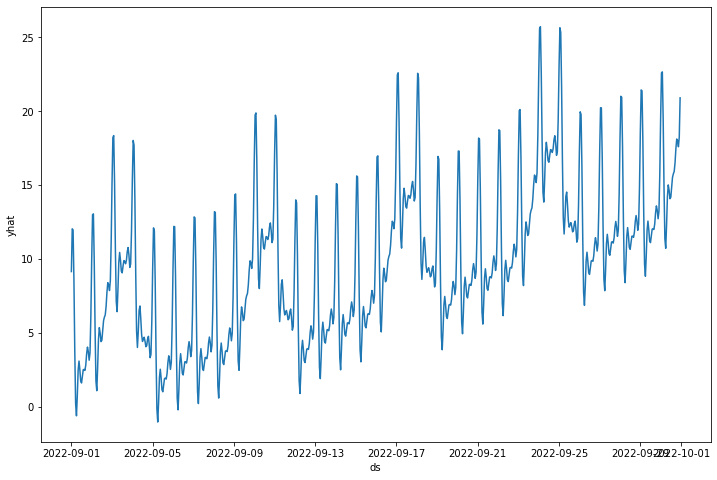

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.lineplot(x='ds', y='yhat', data=forecast2)

## Analyst of future prediction

In [15]:
name_of_day = []
hours       = []

for i in range(len(forecast2['ds'])):
    day  = forecast2['ds'][i].strftime("%A")
    hour = forecast2['ds'][i].strftime("%H")
    name_of_day.append(day)
    hours.append(hour)

forecast2['Name_of_Day'] = name_of_day
forecast2['Hours'] = hours

Let's Calculate the average passenger by day

In [16]:
customer_day = forecast2.groupby('Name_of_Day').agg({'yhat' : 'mean'}).reset_index().sort_values(by='yhat', ascending=False)
customer_day

,Name_of_Day,yhat
2,Saturday,14.137629
0,Friday,11.227861
3,Sunday,10.420380
6,Wednesday,8.661582
4,Thursday,8.175494
5,Tuesday,8.149167
1,Monday,7.168655


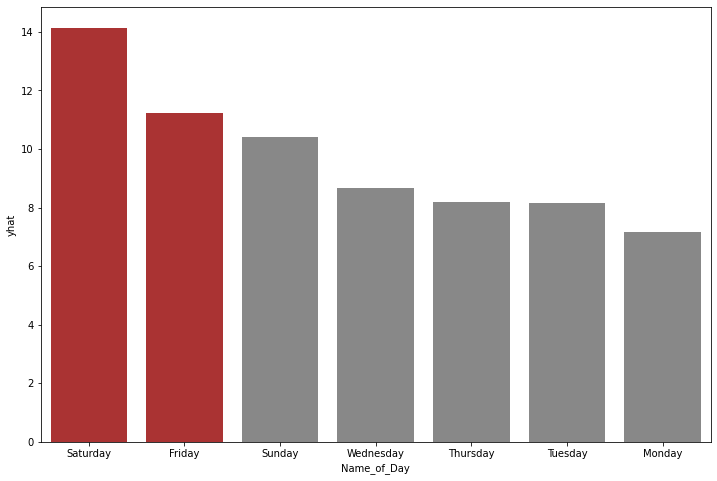

In [17]:
# make it to graph
plt.figure(figsize=(12,8))
ax = sns.barplot(y='yhat', x='Name_of_Day', data=customer_day)

for bar in ax.patches:
    bar.set_facecolor('#888888')

ax.patches[0].set_facecolor('#aa3333')
ax.patches[1].set_facecolor('#aa3333')

Now let's see what time has the highest average number of passengers

Text(0, 0.5, 'Total Customer')

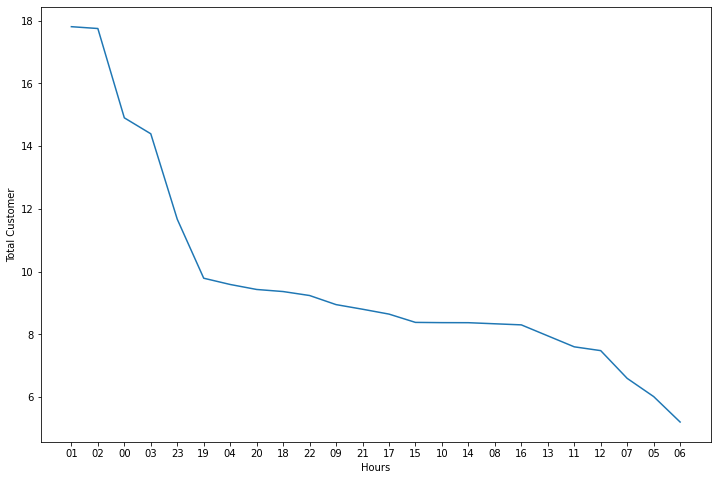

In [18]:
customer_hour = forecast2.groupby('Hours').agg({'yhat' : 'mean'}).reset_index().sort_values(by='yhat', ascending=False)

plt.figure(figsize=(12,8))
ax = sns.lineplot(y='yhat', x='Hours', data=customer_hour)
plt.ylabel('Total Customer')

From the two graphs above, we can conclude that locations with ID 4 have the highest number of passengers on Saturday and Friday. and the busiest hours are between 23:00 and 03:00 so it is recommended that at that time the operations team of the NYC taxi commission sends sufficient taxi fleets (around 15-20 taxis). besides these hours, it is enough to prepare 10 taxi fleets

## Want To see an average customer per hours in each day? See this code

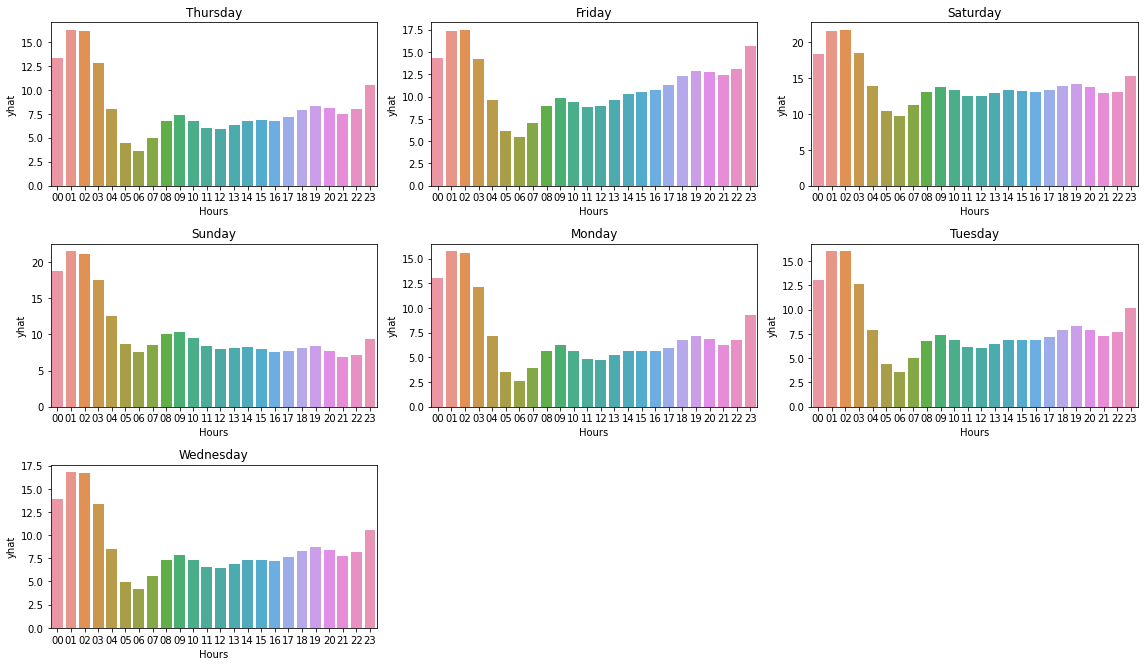

In [19]:
x = 1
day = list(forecast2['Name_of_Day'].unique())
plot = 3

plt.figure(figsize=(16,12))
for i in day:
    a = forecast2[forecast2['Name_of_Day'] == i].groupby('Hours').agg({'yhat' : 'mean'}).reset_index().sort_values(by='Hours', ascending=True)
    plt.subplot(4,3,x)
    sns.barplot(y='yhat', x='Hours', data= a)
    plt.title(i)
    plt.tight_layout()
    x += 1
plt.show()